## Import Libraries

In [ ]:
!pip install --upgrade pip
!pip install pydot

Requirement already up-to-date: pip in /opt/venv/lib/python3.7/site-packages (20.2.2)


In [ ]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.xkcd()

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Input, Embedding, Reshape, Activation, Dropout, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform, he_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2, l1_l2
from keras import backend as K
from keras.utils import plot_model,normalize

import keras
import pydot as pyd

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## Import and organise data

In [ ]:
df_rating = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u1.base', sep = '\t', engine='python', header=None)
df_rating.columns = ['UserId', 'MovieId', 'Rating', 'Timestamp']
df_rating_test = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u1.test', sep = '\t', engine='python', header=None)

df_users = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.user', sep = '|', engine='python', header=None)
df_users.columns = ['UserId', 'Age', 'Gender', 'Occupation', 'ZipCode']
df_users.set_index('UserId', inplace = True)
df_items = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.item', sep = '|', engine='python', encoding ='ISO-8859-1', header=None)
df_items.columns = ['MovieId', 'Title', 'Date', 'VideoReleaseDate', 'Url', 'unknown', 'Action','Adventure', 'Animation', 
                    'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror','Musical', 'Mystery', 'Romance', 
                    'Sci-Fi', 'Thriller', 'War', 'Western']
df_items.set_index('MovieId', inplace = True)

df_matrix = df_rating.pivot(index='UserId', columns='MovieId', values='Rating')

n_users = len(df_users)
n_items = len(df_items)

In [ ]:
df_matrix

MovieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,NaN,4.0,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_users

,Age,Gender,Occupation,ZipCode
UserId,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213
...,...,...,...,...
939,26,F,student,33319
940,32,M,administrator,02215
941,20,M,student,97229


In [ ]:
df_items

,Title,Date,VideoReleaseDate,Url,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Soma data-manipulation functions

In [ ]:
def get_pos(df, anchor):
    """
        Given a user id anchor, it gives back the list of liked item ids.
        
        Parameters
        ----------
            df : Pandas DataFrame
                    Dataframe containing ratings, having user id as rows, movie id as columns
                    
            anchor : int
                        user id to be serving as anchor.
        
        Return
        ------
            pos_list : list of int
                        list of P elements
                        values : Positive (Movie id evaluated at least 4.0)                              
    """
    POS_THR = 4.0
    
    ps = df.loc[anchor] >= POS_THR 
    return ps[ps].index.values

In [ ]:
def get_neg(df, anchor):
    """
        Given a user id anchor, it gives back the list of unliked item ids.
        
        Parameters
        ----------
            df : Pandas DataFrame
                    Dataframe containing ratings, having user id as rows, movie id as columns
                    
            anchor : int
                        user id to be serving as anchor.
        
        Return
        ------
            neg_list : list of int
                        list of N elements
                        values : Negative (Movie id evaluates at most 2.0)
    """
    NEG_THR = 3.0
    
    ps = df.loc[anchor] <= NEG_THR 
    return ps[ps].index.values

In [ ]:
user_con_features = ["Age"]
user_cat_features = ["Gender", "Occupation"]

item_features = ['Action','Adventure', 'Animation', 
                'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 
                'Fantasy','Film-Noir', 'Horror','Musical', 'Mystery', 'Romance', 
                'Sci-Fi', 'Thriller', 'War', 'Western']

In [ ]:
df_users

,Age,Gender,Occupation,ZipCode
UserId,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213
...,...,...,...,...
939,26,F,student,33319
940,32,M,administrator,02215
941,20,M,student,97229


## Pre-processing input arrays

In [ ]:
def process_features(df, con_features, cat_features):
    """
        Given a dataframe, it gives back its feature vector.
        
        Parameters
        ----------
            df : Pandas DataFrame
                      Dataframe containing metadata.
                      
            cat_features : list of str
                            list of categorical variables, columns of df.
            
            con_features : list of str
                            list of continuous variables, columns of df.
        
        Return
        ------
            X : array of shape (len(df), n_encoded_features)
                        X is a matrix having as rows id feature vectors.

                    
    """

    # initialise an empty lists of vectors
    X_cat = []
    X_con = []

    # for each continuous feature, add it as it is.
    for column in con_features:
        X = np.array(df[column])
        X_con.append(X)

    # for each categorical feature, get the numerical encoding of the feature vector
    for column in cat_features:
        X = np.asarray(df[column].tolist())
        X_line = pd.factorize(X)[0]
        X_cat.append(np.asarray(X_line))
    
    # transform lists in arrays
    try:
        X_con = np.column_stack(X_con)
    except:
        pass

    try:    
        X_cat = np.column_stack(X_cat)
    except:
        pass

    # concatenate arrays
    if (len(cat_features) > 0) and (len(con_features) > 0): 
        X = np.concatenate((X_con, X_cat), axis = 1)
    elif len(cat_features) == 0:
        X = X_con
    elif len(con_features) == 0:
        X = X_cat
    # return the encoded features
    return X

In [ ]:
X_usr = process_features(df_users, user_con_features, user_cat_features)
X_item = process_features(df_items, item_features, [])

## Model building

In [ ]:
class TripletLossLayer(Layer):
    """
        Layer object to minimise the triplet loss.
        Here we implement the Bayesian Personal Ranking triplet loss.
    """
    def __init__(self, **kwargs):
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def bpr_triplet_loss(self, inputs):
        """
            Bayesian Personal Ranking triplet loss.
            We make use of log-loss for numerical purposes.
        """
        anchor, positive, negative = inputs
        p_score = K.dot(anchor,K.transpose(positive))
        n_score = K.dot(anchor,K.transpose(negative))
        return K.log(1.0 - K.sigmoid(p_score - n_score))
    
    def call(self, inputs):
        loss = self.bpr_triplet_loss(inputs)
        self.add_loss(loss)
        return loss

class ScoreLayer(Layer):
    """
        Layer object to predict positive matches.
    """
    def __init__(self, **kwargs):
        super(ScoreLayer, self).__init__(**kwargs)
    
    def rec_similarity(self, inputs):
        """
            rec_similarity function
        """
        anchor, item = inputs
        score = K.dot(anchor,K.transpose(item))
        return score
    
    def call(self, inputs):
        pred = self.rec_similarity(inputs)
        return pred

In [ ]:
def build_model(n_users, n_items, emb_dim = 30):
    '''
        Define the Keras Model for training 
        
        Parameters
        ----------
        
            n_users : int
                        number of users
            
            n_items : int
                        number of items
                        
            user_features : list of str
                                list of categorical features (columns of df_users)
            
            item_features : list of str
                                list of categorical features (columns of df_items)
            
            emb_dim : int
                        dimension of the embedding space

    '''
    n_user_features = 3
    n_item_features = 18

    ### Input Layers

    user_input = Input((n_user_features,), name='user_input')
    positive_item_input = Input((n_item_features,), name='pos_item_input')
    negative_item_input = Input((n_item_features,), name='neg_item_input')

    inputs = [user_input, positive_item_input, negative_item_input]

    ### Embedding Layers

    user_emb = Embedding(n_users, emb_dim, input_length=n_user_features, name='user_emb')
    # Positive and negative items will share the same embedding
    item_emb = Embedding(n_items, emb_dim, input_length=n_item_features, name='item_emb')
    # Layer to convert embedding vectors in the same dimensional vectors
    vec_conv64 = Dense(64, name = 'dense_vec64', activation = 'relu')
    vec_conv32 = Dense(32, name = 'dense_vec32', activation = 'relu')
    vec_conv = Dense(emb_dim, name = 'dense_vec', activation = 'softmax')
    

    # Anchor
    a = Flatten(name = 'flatten_usr_emb')(user_emb(user_input))
    a = Dense(emb_dim, name = 'dense_user', activation = 'softmax')(a)
    
    # Positive
    p = Flatten(name = 'flatten_pos_emb')(item_emb(positive_item_input))
    #p = vec_conv64(p)
    p = vec_conv32(p)
    p = vec_conv(p)

    # Negative
    n = Flatten(name = 'flatten_neg_emb')(item_emb(negative_item_input))
    #n = vec_conv64(n)
    n = vec_conv32(n)
    n = vec_conv(n)

    #Force the encoding to live on the d-dimentional hypershpere
    #a = Lambda(lambda x: K.l2_normalize(x), name = 'normalise_layer_a')(a)
    #p = Lambda(lambda x: K.l2_normalize(x), name = 'normalise_layer_p')(p)
    #n = Lambda(lambda x: K.l2_normalize(x), name = 'normalise_layer_n')(n)

    # Score layers
    p_rec_score = ScoreLayer(name='pos_recommendation_score')([a, p])
    n_rec_score = ScoreLayer(name='neg_recommendation_score')([a, n])
    
    # TripletLoss Layer
    loss_layer = TripletLossLayer(name='triplet_loss_layer')([a, p, n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=inputs, outputs=loss_layer, name = 'training_model')

    network_predict = Model(inputs=inputs[:-1], outputs=p_rec_score, name = 'inference_model')

    # return the model
    return network_train, network_predict

In [ ]:
network_train, network_predict = build_model(n_users, n_items)
optimizer = Adam(lr = 0.001)
network_train.compile(loss=None,optimizer=optimizer)
network_train.summary()
#plot_model(network_train,show_shapes=True, show_layer_names=True, to_file='model.png')
n_iteration=0

Model: "training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pos_item_input (InputLayer)     [(None, 18)]         0                                            
__________________________________________________________________________________________________
neg_item_input (InputLayer)     [(None, 18)]         0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, 3)]          0                                            
__________________________________________________________________________________________________
item_emb (Embedding)            (None, 18, 30)       50460       pos_item_input[0][0]             
                                                                 neg_item_input[0][0]

In [ ]:
network_predict.layers

In [ ]:
network_train.layers

## Training phase

### Building batch

In [ ]:
def cosine_dist(x,y, eps = 1e-6):
    """
        Cosine distance between vectors.

        Parameters
        ----------
            x : numpy array

            y : numpy array

            eps : float
                    little number to avoid zero division error.
                    default : 1e-6

        Return
        ------
            dist = 1 - (x.y)/(||x||||y||)
    """
    return 1 - np.dot(x,y.T)/(np.linalg.norm(x)*np.linalg.norm(y) + eps)

In [ ]:
def build_batch(batch_size, X_usr, X_item, df, return_cache = False):
    """
        Returns the list of three arrays to feed the model.
        
        Parameters
        ----------
            batch_size : int
                            size of the batch.
            
            X_usr : numpy array of shape (n_users, n_user_features)
                            array of user metadata.
            
            X_item : numpy array of shape (n_items, n_item_features)
                            array of item metadata.
            
            df : Pandas DataFrame
                    dataframe containing user-item ratings.
            
            return_cache : bool
                            parameter to trigger whether we want the list of ids corresponding to 
                            triplets.
                            default: False
                        
        Returns
        -------
            triplets : list of numpy arrays
                        list containing 3 tensors A,P,N corresponding to:
                            - Anchor A : (batch_size, n_user_features)
                            - Positive P : (batch_size, n_item_features)
                            - Negative N : (batch_size, n_item_features)
    """
    # constant values
    n_user_features = X_usr.shape[1]
    n_item_features = X_item.shape[1]

    # define user_list
    user_list = list(df.index.values)

    # initialise result
    triplets = [np.zeros((batch_size, n_user_features)), # anchor
                np.zeros((batch_size, n_item_features)), # pos
                np.zeros((batch_size, n_item_features))  # neg
                ]
    user_ids = []
    p_ids = []
    n_ids = []

    for i in range(batch_size):
        # pick one random user for anchor
        anchor_id = random.choice(user_list)
        user_ids.append(anchor_id) 

        # all possible positive/negative samples for selected anchor
        p_item_ids = get_pos(df, anchor_id)
        n_item_ids = get_neg(df, anchor_id)

        # pick one of the positve ids
        try:
            positive_id = random.choice(p_item_ids)
        except IndexError:
            positive_id = 0

        p_ids.append(positive_id)

        # pick one of the negative ids
        try:
            negative_id = random.choice(n_item_ids)
        except IndexError:
            negative_id = 0
        
        n_ids.append(negative_id)

        # define triplet
        triplets[0][i,:] = X_usr[anchor_id-1][:]
        
        if positive_id == 0:
            triplets[1][i,:] = np.zeros((n_item_features,))
        else:
            triplets[1][i,:] = X_item[positive_id-1][:]
        
        if negative_id == 0:
            triplets[2][i,:] = np.zeros((n_item_features,))
        else:
            triplets[2][i,:] = X_item[negative_id-1][:]

    if return_cache:
        cache = {'users': user_ids, 'positive': p_ids, 'negative': n_ids}
        return triplets, cache
    
    return triplets

In [ ]:
def get_triplets_hard(batch_size, X_usr, X_item, df, return_cache = False):
    """
        Returns the list of three arrays to feed the model.
        
        Parameters
        ----------
            batch_size : int
                            size of the batch.
            
            X_usr : numpy array of shape (n_users, n_user_features)
                            array of user metadata.
            
            X_item : numpy array of shape (n_items, n_item_features)
                            array of item metadata.
            
            df : Pandas DataFrame
                    dataframe containing user-item ratings.
            
            return_cache : bool
                            parameter to triggere whether we want the list of ids corresponding to 
                            triplets.
                            default: False
                        
        Returns
        -------
            triplets : list of numpy arrays
                        list containing 3 tensors A,P,N corresponding to:
                            - Anchor A : (batch_size, n_user_features)
                            - Positive P : (batch_size, n_item_features)
                            - Negative N : (batch_size, n_item_features)
    """
    # constant values
    n_user_features = X_usr.shape[1]
    n_item_features = X_item.shape[1]

    # define user_list
    user_list = list(df.index.values)

    # initialise result
    triplets = [np.zeros((batch_size, n_user_features)), # anchor
                np.zeros((batch_size, n_item_features)), # pos
                np.zeros((batch_size, n_item_features))  # neg
                ]
    user_ids = []
    p_ids = []
    n_ids = []
    
    for i in range(batch_size):
        # pick one random user for anchor
        anchor_id = random.choice(user_list)
        user_ids.append(anchor_id) 
        
        # all possible positive/negative samples for selected anchor
        p_item_ids = get_pos(df, anchor_id)
        n_item_ids = get_neg(df, anchor_id)
        
        # pick one of the positve ids
        try:
            positive_id = random.choice(p_item_ids)
        except IndexError:
            positive_id = 0

        p_ids.append(positive_id)
        
        # pick the most similar negative id
        try:
            n_min = np.argmin([(cosine_dist(X_item[positive_id-1], X_item[k-1])) for k in n_item_ids])
            negative_id = n_item_ids[n_min]
        except:
            try:
                negative_id = random.choice(n_item_ids)
            except IndexError:
                negative_id = 0
            
        n_ids.append(negative_id)
        
        # define triplet
        triplets[0][i,:] = X_usr[anchor_id-1][:]
        
        if positive_id == 0:
            triplets[1][i,:] = np.zeros((n_item_features,))
        else:
            triplets[1][i,:] = X_item[positive_id-1][:]
        
        if negative_id == 0:
            triplets[2][i,:] = np.zeros((n_item_features,))
        else:
            triplets[2][i,:] = X_item[negative_id-1][:]

    if return_cache:
        cache = {'users': user_ids, 'positive': p_ids, 'negative': n_ids}
        return triplets, cache
    
    return triplets

In [ ]:
get_triplets_hard(1, X_usr, X_item, df_matrix, return_cache = True)

([array([[30.,  0.,  7.]]),
  array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0.]]),
  array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0.]])],
 {'users': [479], 'positive': [283], 'negative': [131]})

### Training over batches

In [ ]:
# Hyper parameters
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 10
n_iter = 100000 # No. of training iterations
n_val = 1000 # how many one-shot tasks to validate on

In [ ]:
import time
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()

for i in range(1, n_iter+1):
    triplets = get_triplets_hard(batch_size, X_usr, X_item, df_matrix)
    loss = network_train.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,loss,n_iteration))

# serialize weights to HDF5
network_train.save_weights("network_train.h5")
network_predict.save_weights("network_predict.h5")
print("Saved model to disk")


[75100] Time for 75100 iterations: 37.8 mins, Train Loss: -0.7171703577041626

 ------------- 

[75200] Time for 75200 iterations: 37.9 mins, Train Loss: -0.6931471824645996

 ------------- 

[75300] Time for 75300 iterations: 37.9 mins, Train Loss: -0.7791815996170044

 ------------- 

[75400] Time for 75400 iterations: 38.0 mins, Train Loss: -0.8171697854995728

 ------------- 

[75500] Time for 75500 iterations: 38.1 mins, Train Loss: -0.8171700835227966

 ------------- 

[75600] Time for 75600 iterations: 38.1 mins, Train Loss: -0.7791815400123596

 ------------- 

[75700] Time for 75700 iterations: 38.2 mins, Train Loss: -0.7411929368972778

 ------------- 

[75800] Time for 75800 iterations: 38.2 mins, Train Loss: -0.6791815757751465

 ------------- 

[75900] Time for 75900 iterations: 38.3 mins, Train Loss: -0.7551586031913757

 ------------- 

[76000] Time for 76000 iterations: 38.3 mins, Train Loss: -0.7411945462226868

 ------------- 

[76100] Time for 76100 iterations: 38.4

## Evaluation

In [ ]:
network_predict.predict([X_usr[:1], X_item[7:8]])

array([[1.166189e-13]], dtype=float32)

In [ ]:
network_predict.predict([X_usr[:1], X_item[:1]])

1.0

In [ ]:
import math

In [ ]:
def compute_probs(network,X_usr,X_item, thrs = 0.5):
    '''
    Input
        network : current NN to compute embeddings
        X_usr : tensor of shape (m,n_user_features) containing pics to evaluate
        X_item: tensor of shape (m,n_item_features) containing true liked item
        thrs: float, threshold to separate liked and not liked items
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X_usr.shape[0]
    nbevaluation = int(m**2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #For each user and item of our dataset
    k = 0
    for i in range(1,m):
        for j in range(1,m):
            probs[k] = float(network.predict([X_usr[i-1:i], X_item[j-1:j]]))
            if probs[k] > thrs:
                y[k] = 1
            else:
                y[k] = 0    
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,img_rows,img_cols,1))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network,n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))

    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()

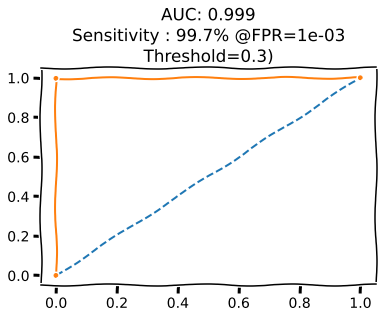

In [ ]:
#Testing
probs,yprob = compute_probs(network_predict,X_usr[:100],X_item[:100], thrs=0.2)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)